In [1]:
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure

from queries import pyg_queries, utils
from config.base import MODEL_CFG, DATASET_CFG

from queries.feature_queries import (
    IdentityEncoder,
    ListEncoder,
    load_edge_tensor,
    load_node_tensor,
)
from queries.utils import read_ddf_from_disk
from models.models_v3 import Model
from config.base import (
    DIR_CFG,
    MODEL_CFG,
    DATASET_CFG,
)

import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F

seed_everything(MODEL_CFG['RANDOM_SEED'])


In [2]:

class RandomValueEncoder(object):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, df):
        return torch.rand(len(df), self.dim)


def create_pyg_graph(
    sampling_rate=MODEL_CFG['SAMPLING_RATIO'],
    dataset_cfg=DATASET_CFG,
):
    data = HeteroData()
    mappings = {}
    dir_name = f"{DIR_CFG['DATASETS_DIR']}{sampling_rate}"
    node_file_paths = list(
        map(
            (lambda cfg: cfg['FILE_NAME']),
            dataset_cfg['NODE_TYPES']
        )
    )
    rel_file_paths = list(
        map(
            (lambda cfg: cfg['FILE_NAME']),
            dataset_cfg['REL_TYPES']
        )
    )

    if 'taxon_nodes.csv' in node_file_paths:
        taxon_x, taxon_mapping = load_node_tensor(
            filename=f'{dir_name}/taxon_nodes.csv',
            index_col='appId',
            encoders={
                # 'rankEncoded': IdentityEncoder(
                #     dtype=torch.long, is_tensor=True),
                # 'features': ListEncoder(),
                'features': RandomValueEncoder(),
                # 'FastRP_embedding': ListEncoder(),
            }
        )
        data['taxon'].node_id = torch.arange(len(taxon_x))
        data['taxon'].x = taxon_x
        mappings['taxon'] = taxon_mapping

    if 'sotu_nodes.csv' in node_file_paths:
        sotu_x, sotu_mapping = load_node_tensor(
            filename=f'{dir_name}/sotu_nodes.csv',
            index_col='appId',
            encoders={
                # 'centroidEncoded': IdentityEncoder(
                #   dtype=torch.long, is_tensor=True),
                # 'features': ListEncoder(),
                'features': RandomValueEncoder(),
                # 'FastRP_embedding': ListEncoder(),
            }
        )
        data['sotu'].node_id = torch.arange(len(sotu_x))
        data['sotu'].x = sotu_x #torch.arange(0, len(sotu_mapping))
        mappings['sotu'] = sotu_mapping

    # if 'tissue_nodes.csv' in node_file_paths:
    #     tissue_x, tissue_mapping = load_node_tensor(
    #         filename=f'{dir_name}/tissue_nodes.csv',
    #         index_col='appId',
    #         encoders={
    #             # 'centroidEncoded': IdentityEncoder(
    #             #   dtype=torch.long, is_tensor=True),
    #             'features': ListEncoder(),
    #             # 'FastRP_embedding': ListEncoder(),
    #         }
    #     )
    #     data['tissue'].x = tissue_x # torch.arange(0, len(tissue_mapping))
    #     mappings['tissue'] = tissue_mapping

    if 'sotu_has_host_stat_edges.csv' in rel_file_paths:
        edge_index, edge_label = load_edge_tensor(
            filename=f'{dir_name}/sotu_has_host_stat_edges.csv',
            src_index_col='sourceAppId',
            src_mapping=sotu_mapping,
            dst_index_col='targetAppId',
            dst_mapping=taxon_mapping,
            # encoders={
            #     'weight': IdentityEncoder(dtype=torch.float, is_tensor=True),
            #     'weight': BinaryEncoder(dtype=torch.long),
            # },
        )
        # edge_label = torch.div(edge_label, 100)
        data['sotu', 'has_host', 'taxon'].edge_index = edge_index
        data['sotu', 'has_host', 'taxon'].edge_label = edge_label

    # if 'taxon_has_parent_edges.csv' in rel_file_paths:
    #     edge_index, edge_label = load_edge_tensor(
    #         filename=f'{dir_name}/taxon_has_parent_edges.csv',
    #         src_index_col='sourceAppId',
    #         src_mapping=taxon_mapping,
    #         dst_index_col='targetAppId',
    #         dst_mapping=taxon_mapping,
    #         encoders={
    #             'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
    #         },
    #     )
    #     data['taxon', 'has_parent', 'taxon'].edge_index = edge_index
    #     data['taxon', 'has_parent', 'taxon'].edge_label = edge_label

    # if 'tissue_has_parent_edges.csv' in rel_file_paths:
    #     edge_index, edge_label = load_edge_tensor(
    #         filename=f'{dir_name}/tissue_has_parent_edges.csv',
    #         src_index_col='sourceAppId',
    #         src_mapping=tissue_mapping,
    #         dst_index_col='targetAppId',
    #         dst_mapping=tissue_mapping,
    #         encoders={
    #             'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
    #         },
    #     )
    #     data['tissue', 'has_parent', 'tissue'].edge_index = edge_index
    #     data['tissue', 'has_parent', 'tissue'].edge_label = edge_label

    # if 'sotu_sequence_alignment_edges.csv' in rel_file_paths:
    #     edge_index, edge_label = load_edge_tensor(
    #         filename=f'{dir_name}/sotu_sequence_alignment_edges.csv',
    #         src_index_col='sourceAppId',
    #         src_mapping=sotu_mapping,
    #         dst_index_col='targetAppId',
    #         dst_mapping=sotu_mapping,
    #         encoders={
    #             'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
    #         },
    #     )
    #     data['sotu', 'sequence_alignment', 'sotu'].edge_index = edge_index
    #     data['sotu', 'sequence_alignment', 'sotu'].edge_label = edge_label

    # if 'sotu_has_inferred_taxon_edges.csv' in rel_file_paths:
    #     edge_index, edge_label = load_edge_tensor(
    #         filename=f'{dir_name}/sotu_has_inferred_taxon_edges.csv',
    #         src_index_col='sourceAppId',
    #         src_mapping=sotu_mapping,
    #         dst_index_col='targetAppId',
    #         dst_mapping=taxon_mapping,
    #         encoders={
    #             'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
    #         },
    #     )
    #     data['sotu', 'has_inferred_taxon', 'taxon'].edge_index = edge_index
    #     data['sotu', 'has_inferred_taxon', 'taxon'].edge_label = edge_label

    node_types, edge_types = data.metadata()
    data = T.ToUndirected()(data)
    # if not ('taxon', 'rev_has_host', 'sotu') in edge_types:
    #     data = T.ToUndirected()(data)
        # Remove "reverse" label. (redundant if using link loader)
        # del data['taxon', 'rev_has_host', 'sotu'].edge_label
    return data, mappings


In [12]:
data, mappings = create_pyg_graph()

In [26]:
# df[4].sample(frac=1).values
x = data['sotu', 'has_host', 'taxon'].edge_index[1]
rand = torch.randperm(736471)
data['sotu', 'has_host', 'taxon'].edge_index[1] = data['sotu', 'has_host', 'taxon'].edge_index[1][rand]
print(data['sotu', 'has_host', 'taxon'].edge_index[1])

print(data['sotu', 'has_host', 'taxon'].edge_index[1][rand])

tensor([1707641,  207201, 1574147,  ..., 2397327, 2263669, 1271946])
tensor([1922033,  493036,  462066,  ...,  493036, 2404853, 1778056])


[('9443', 34484), ('80840', 33980), ('91347', 28776), ('2732544', 28637), ('38820', 25454), ('72274', 22067), ('94695', 21236), ('9989', 19856), ('3699', 19693), ('186826', 17545)]


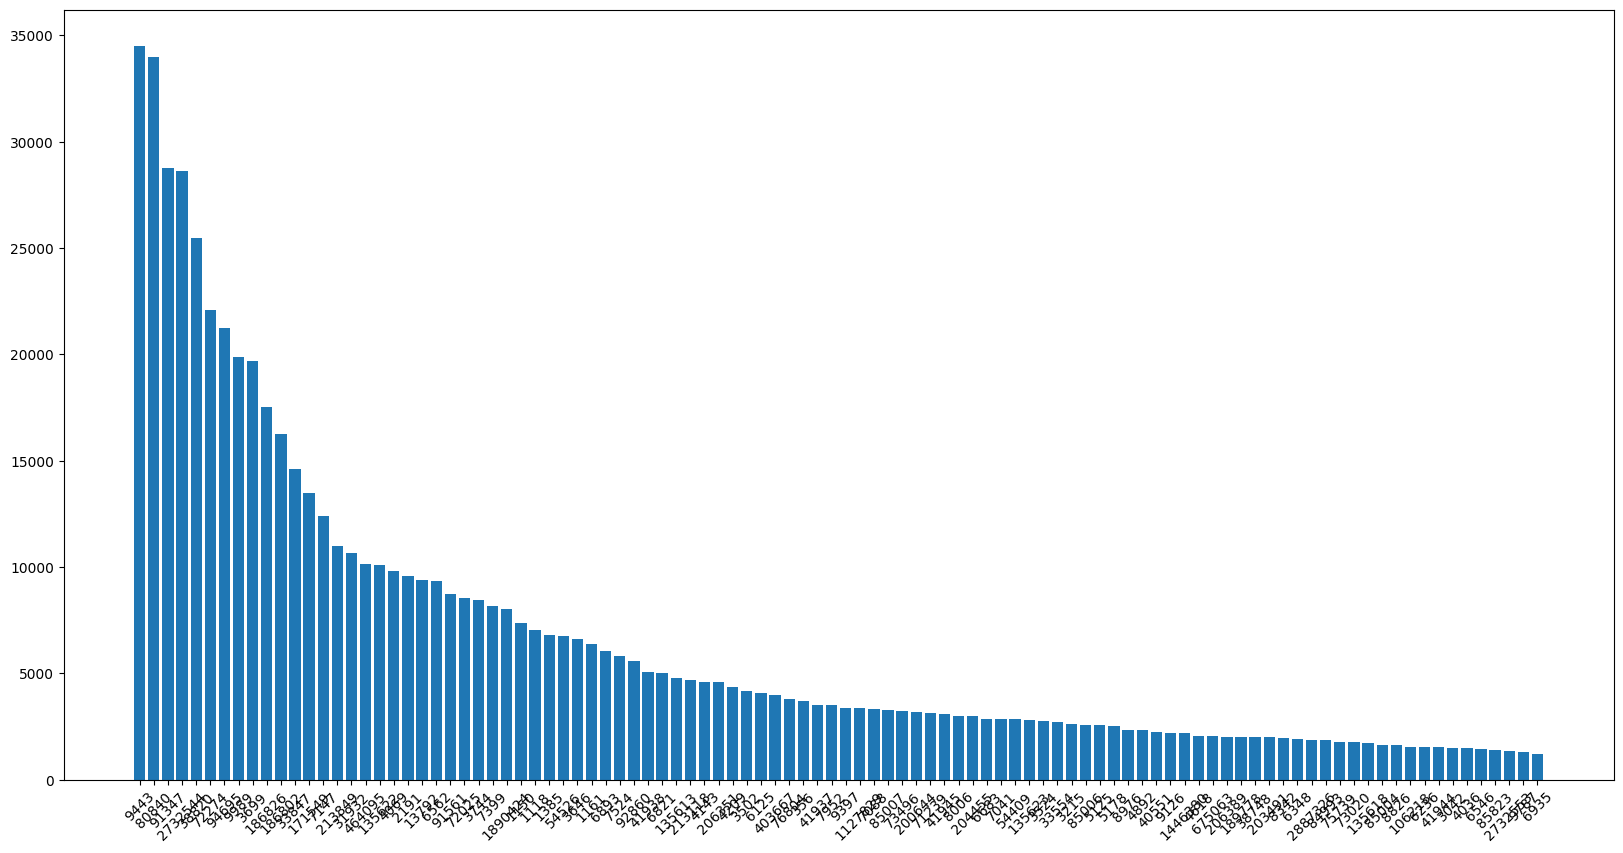

In [27]:
inv_taxon_map = {v: k for k, v in mappings['taxon'].items()}
plot_data = data['sotu', 'has_host', 'taxon'].edge_index[1].cpu().numpy()
plot_data = [
    str(inv_taxon_map[node_id])
    for node_id in plot_data
]
c = Counter(plot_data)
print(c.most_common(10))

most_common = dict(c.most_common(100))
figure(figsize=(20, 10))
plt.bar(most_common.keys(), most_common.values())
plt.xticks(rotation=45)
plt.show()

In [5]:
plot_data = data['sotu', 'has_host', 'taxon'].edge_index[1].cpu().numpy()
c = Counter(plot_data)
most_common = dict(c.most_common(100))

most_common_taxons = most_common.keys()
A = data['sotu', 'has_host', 'taxon'].edge_index[1].clone().detach()
# mask = sum(A == i for i in most_common_taxons ).bool()
mask = A.apply_(lambda x: x not in most_common_taxons).bool()
indices = torch.nonzero(mask)
print(len(data['sotu', 'has_host', 'taxon'].edge_index[1]))
print(len(data['sotu', 'has_host', 'taxon'].edge_index[1][mask]))


new_edge_index = torch.stack([
    data['sotu', 'has_host', 'taxon'].edge_index[0][mask],
    data['sotu', 'has_host', 'taxon'].edge_index[1][mask],
])

data['sotu', 'has_host', 'taxon'].edge_index = new_edge_index
# data['sotu', 'has_host', 'taxon'].edge_index_label = new_edge_index_label

736471
74877


In [28]:
transform = T.RandomLinkSplit(
    num_val=0.8, #0.1
    num_test=0.1, #0.1
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=4.0,
    add_negative_train_samples=False,
    edge_types=("sotu", "has_host", "taxon"),
    rev_edge_types=("taxon", "rev_has_host", "sotu"), 
)

train_data, val_data, test_data = transform(data)

In [29]:
edge_label_index = train_data["sotu", "has_host", "taxon"].edge_label_index
edge_label = train_data["sotu", "has_host", "taxon"].edge_label


train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=4.0,
    edge_label_index=(("sotu", "has_host", "taxon"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

sampled_data = next(iter(train_loader))
# print(sampled_data["sotu", "has_host", "taxon"].edge_label.min())
# print(sampled_data)

In [30]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):
    def forward(self, x_user, x_movie, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(1, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["sotu"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["taxon"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data):
        x_dict = {
          "sotu": self.user_emb(data["sotu"].node_id),
          "taxon": self.movie_lin(data["taxon"].x) + self.movie_emb(data["taxon"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["sotu"],
            x_dict["taxon"],
            data["sotu", "has_host", "taxon"].edge_label_index,
        )

        return pred

        
model = Model(hidden_channels=64)

print(model)

Model(
  (movie_lin): Linear(in_features=1, out_features=64, bias=True)
  (user_emb): Embedding(513176, 64)
  (movie_emb): Embedding(2501873, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (sotu__has_host__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_host__sotu): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (sotu__has_host__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_host__sotu): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [43]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)

        # orig = sampled_data['sotu', 'has_host', 'taxon'].edge_index[1]
        # rand = torch.randperm(orig.shape[0])
        # sampled_data['sotu', 'has_host', 'taxon'].edge_index[1] = orig[rand]
        pred = model(sampled_data)

        ground_truth = sampled_data["sotu", "has_host", "taxon"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|██████████| 173/173 [01:41<00:00,  1.70it/s]


Epoch: 001, Loss: 0.0028


100%|██████████| 173/173 [01:39<00:00,  1.73it/s]


Epoch: 002, Loss: 0.0019


100%|██████████| 173/173 [01:38<00:00,  1.75it/s]


Epoch: 003, Loss: 0.0019


100%|██████████| 173/173 [01:38<00:00,  1.75it/s]


Epoch: 004, Loss: 0.0024


100%|██████████| 173/173 [01:40<00:00,  1.73it/s]

Epoch: 005, Loss: 0.0024


In [44]:
edge_label_index = val_data["sotu", "has_host", "taxon"].edge_label_index
edge_label = val_data["sotu", "has_host", "taxon"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("sotu", "has_host", "taxon"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  taxon={
    node_id=[271],
    x=[271, 1],
    n_id=[271],
    num_sampled_nodes=[3],
  },
  sotu={
    node_id=[2967],
    x=[2967, 1],
    n_id=[2967],
    num_sampled_nodes=[3],
  },
  (sotu, has_host, taxon)={
    edge_index=[2, 2699],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[2699],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (taxon, rev_has_host, sotu)={
    edge_index=[2, 5532],
    e_id=[5532],
    num_sampled_edges=[2],
  }
)


In [45]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["sotu", "has_host", "taxon"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
aupr = average_precision_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
print(f"precision Acc: {aupr:.4f}")

100%|██████████| 7672/7672 [00:20<00:00, 382.52it/s]



Validation AUC: 0.9995
precision Acc: 0.9990
